In [12]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the NetCDF file
ds = xr.open_dataset('/data/GLOBARGO/data/15228690/fseq_OCIM2_48L.nc', chunks={'time': 1})

# Print structure to understand the file better
ds = ds.assign_coords(time=np.arange(0, 1001))  # 0–1000 years, total 1001 steps

In [16]:
# Select the closest time to 50 years
ds_50yr = ds.sel(time=50, method='nearest')

# 2. Select 50-year data (convert to NumPy)
ds_50yr = ds.sel(time=50, method='nearest')
fseq_50yr_np = ds_50yr['fseq'].compute().data

In [17]:
mask_np = ds['MASK'].compute().data

# 3. Reconstruct 3D array
fseq_3d_np = np.full_like(mask_np, np.nan, dtype=float)
fseq_3d_np[mask_np == 1] = fseq_50yr_np

# 4. Create xarray DataArray
fseq_3d = xr.DataArray(
    fseq_3d_np,
    dims=ds['MASK'].dims,
    coords={dim: ds[dim] for dim in ds['MASK'].dims}
)

# 5. Filter depths ≤1000m
depth_mask = (ds['DEPTH'] <= 1000) & (ds['MASK'] == 1)
fseq_shallow = fseq_3d.where(depth_mask.compute())  # Compute the mask if Dask-backed

(array([1.90000e+01, 8.90000e+01, 1.23759e+05, 4.47380e+04, 2.87130e+04,
        2.23770e+04, 1.85530e+04, 1.61370e+04, 2.28000e+02, 1.50000e+01]),
 array([-0.51093393, -0.31749556, -0.12405719,  0.06938118,  0.26281955,
         0.45625792,  0.64969629,  0.84313466,  1.03657303,  1.2300114 ,
         1.42344977]),
 <BarContainer object of 10 artists>)

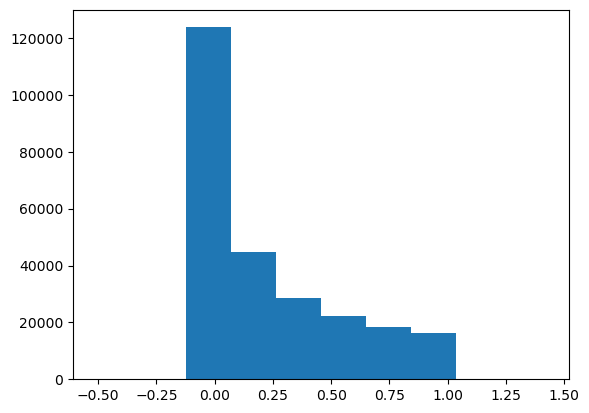

In [23]:
unique_values = np.unique(fseq_shallow.values)
fseq_shallow.plot.hist()

In [28]:
# Ensure fseq_shallow is computed (if Dask-backed)
fseq_valid = fseq_shallow.where((fseq_shallow >= 0) & (fseq_shallow <= 1)).compute()

# Convert to a Pandas DataFrame with coordinates
df = fseq_valid.to_dataframe(name='fseq').reset_index()

df_clean = df.dropna(subset=['fseq'])
df_clean

,depth,longitude,latitude,fseq
9,0,0,9,0.000000
10,0,0,10,0.000000
11,0,0,11,0.000000
12,0,0,12,0.000000
13,0,0,13,0.000000
...,...,...,...,...
409494,24,179,85,0.813195
409495,24,179,86,0.791981
409496,24,179,87,0.786636
409497,24,179,88,0.794703


In [43]:
# Get all depth values (for levels 0-23 if using 24 levels for 0-1000m)
depth_values = ds['DEPTH'].isel(depth=slice(0, 24)).compute()  # First 24 levels
# Print unique depth values
print("Actual depth values (m):")
print(depth_values.values.flatten())

# Check if differences between levels are constant
depth_diff = np.diff(np.sort(np.unique(depth_values)))
print("\nDifferences between levels (m):")
print(depth_diff)
# Get exact depth values per level
depth_levels = ds['DEPTH'].isel(depth=slice(0, 24)).values.flatten()

np.unique(depth_levels)

Actual depth values (m):
[  4.93454087   4.93454087   4.93454087 ... 831.56158473 831.56158473
 831.56158473]

Differences between levels (m):
[ 9.94293791 10.23836255 10.82921183 11.71548575 12.89718431 14.37430751
 16.14685535 18.21482784 20.57822496 23.23704672 26.19129312 29.44096417
 32.98605985 36.82658018 40.96252514 45.39389475 50.12068899 55.14290788
 60.4605514  66.07361957 71.98211237 78.18602982 84.68537191]


array([  4.93454087,  14.87747878,  25.11584133,  35.94505315,
        47.6605389 ,  60.55772321,  74.93203072,  91.07888608,
       109.29371391, 129.87193887, 153.10898559, 179.30027871,
       208.74124288, 241.72730273, 278.55388291, 319.51640805,
       364.9103028 , 415.03099179, 470.17389966, 530.63445106,
       596.70807063, 668.69018301, 746.87621283, 831.56158473])

In [44]:
# Your 24 unique depth values (in meters)
depth_values = np.array([
    4.93454087, 14.87747878, 25.11584133, 35.94505315,
    47.6605389, 60.55772321, 74.93203072, 91.07888608,
    109.29371391, 129.87193887, 153.10898559, 179.30027871,
    208.74124288, 241.72730273, 278.55388291, 319.51640805,
    364.9103028, 415.03099179, 470.17389966, 530.63445106,
    596.70807063, 668.69018301, 746.87621283, 831.56158473
])

# Create a mapping from level index (0-23) to depth
level_to_depth = {i: depth_values[i] for i in range(len(depth_values))}

<Axes: ylabel='Frequency'>

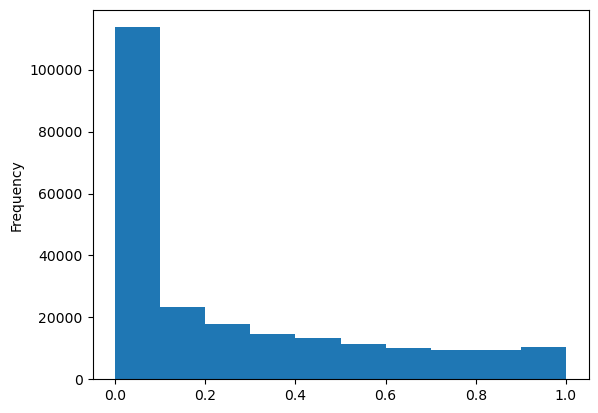

In [51]:
# Map level indices to actual depths
df['depth_meters'] = df['depth'].map(level_to_depth)
df.fseq.plot.hist()

In [53]:
df.to_csv('co2_sequestration_50years.csv', index=False)